<a href="https://colab.research.google.com/github/eentartetekunst/NGS_bioinformatics/blob/main/HW3_edgeR_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# R Kernel in colab

In [ ]:
install.packages("googledrive")
library("googledrive")

if (file.exists("/usr/local/lib/python3.6/dist-packages/google/colab/_ipython.py")){ 
  install.packages("R.utils")
  library("R.utils")
  library("httr")
  my_check <- function() {return(TRUE)}
  reassignInPackage("is_interactive", pkgName = "httr", my_check)
  options(rlang_interactive=TRUE)
} 

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



#  install libs

In [ ]:
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install(version = "3.15")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.rstudio.com


Bioconductor version 3.15 (BiocManager 1.30.19), R 4.2.1 (2022-06-23)

Installing package(s) 'BiocVersion'

Old packages: 'data.table', 'devtools', 'digest', 'jsonlite', 'openssl',
  'pkgload', 'processx', 'ps', 'roxygen2', 'sys', 'tibble', 'tidyverse',
  'vctrs', 'xfun', 'yaml', 'zip', 'foreign', 'mgcv', 'rpart'



In [ ]:
BiocManager::install(c("edgeR"))

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.rstudio.com


Bioconductor version 3.15 (BiocManager 1.30.19), R 4.2.1 (2022-06-23)

Installing package(s) 'edgeR'

also installing the dependencies ‘limma’, ‘locfit’, ‘Rcpp’


Old packages: 'data.table', 'devtools', 'digest', 'jsonlite', 'openssl',
  'pkgload', 'processx', 'ps', 'roxygen2', 'sys', 'tibble', 'tidyverse',
  'vctrs', 'xfun', 'yaml', 'zip', 'foreign', 'mgcv', 'rpart'



In [ ]:
library(edgeR)

Loading required package: limma



In [ ]:
install.packages("statmod")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
install.packages('plotly')
library(plotly) 

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘later’, ‘htmlwidgets’, ‘lazyeval’, ‘crosstalk’, ‘promises’


Loading required package: ggplot2


Attaching package: ‘plotly’


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:stats’:

    filter


The following object is masked from ‘package:graphics’:

    layout




In [ ]:
install.packages('dendextend')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘gridExtra’, ‘viridis’




In [ ]:
library(dendextend)


---------------------
Welcome to dendextend version 1.16.0
Type citation('dendextend') for how to cite the package.

Type browseVignettes(package = 'dendextend') for the package vignette.
The github page is: https://github.com/talgalili/dendextend/

Suggestions and bug-reports can be submitted at: https://github.com/talgalili/dendextend/issues
You may ask questions at stackoverflow, use the r and dendextend tags: 
	 https://stackoverflow.com/questions/tagged/dendextend

	To suppress this message use:  suppressPackageStartupMessages(library(dendextend))
---------------------



Attaching package: ‘dendextend’


The following object is masked from ‘package:stats’:

    cutree




# load data

In [ ]:
GenewiseCounts <- read.csv("/content/GenewiseCounts.csv", row.names = 1)  # row.names = 1 переиндексирует дф по 1 столбцу (названия генов)

# read data

In [ ]:
head(GenewiseCounts) # d 

,Length,B14_5,B15_5,B17_5,B20,B34,C14_5,C15_5,C17_5,C20,C34
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSMUSG00000077223,128,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000044387,414,0,0,0,0,3,0,0,0,0,0
ENSMUSG00000033863,4815,46,60,188,449,4375,54,88,85,189,2934
ENSMUSG00000080626,121,0,0,0,0,3,0,0,0,0,1
ENSMUSG00000006456,3910,740,826,651,474,298,468,673,507,520,310
ENSMUSG00000095913,663,15,10,8,12,5,16,7,9,5,8


In [ ]:
Age <- c(14.5, 15.5, 17.5, 20, 34, 14.5, 15.5, 17.5, 20, 34)
Tissue <- c("B","B","B","B","B", "C", "C", "C", "C", "C")

targets <- data.frame(Age, Tissue)
targets # m

Age,Tissue
<dbl>,<chr>
14.5,B
15.5,B
17.5,B
20.0,B
34.0,B
14.5,C
15.5,C
17.5,C
20.0,C


In [189]:
d = GenewiseCounts[,-1] # we do not need gene length
d = as.matrix(d)
m = data.frame(tissue=substr(colnames(d),1,1),age=as.numeric(sub('_','.',substr(colnames(d),2,10))))
m$col=ifelse(m$tissue=='B','purple','blue')
rownames(m) = colnames(d)
m

,tissue,age,col
,<chr>,<dbl>,<chr>
B14_5,B,14.5,purple
B15_5,B,15.5,purple
B17_5,B,17.5,purple
B20,B,20.0,purple
B34,B,34.0,purple
C14_5,C,14.5,blue
C15_5,C,15.5,blue
C17_5,C,17.5,blue
C20,C,20.0,blue


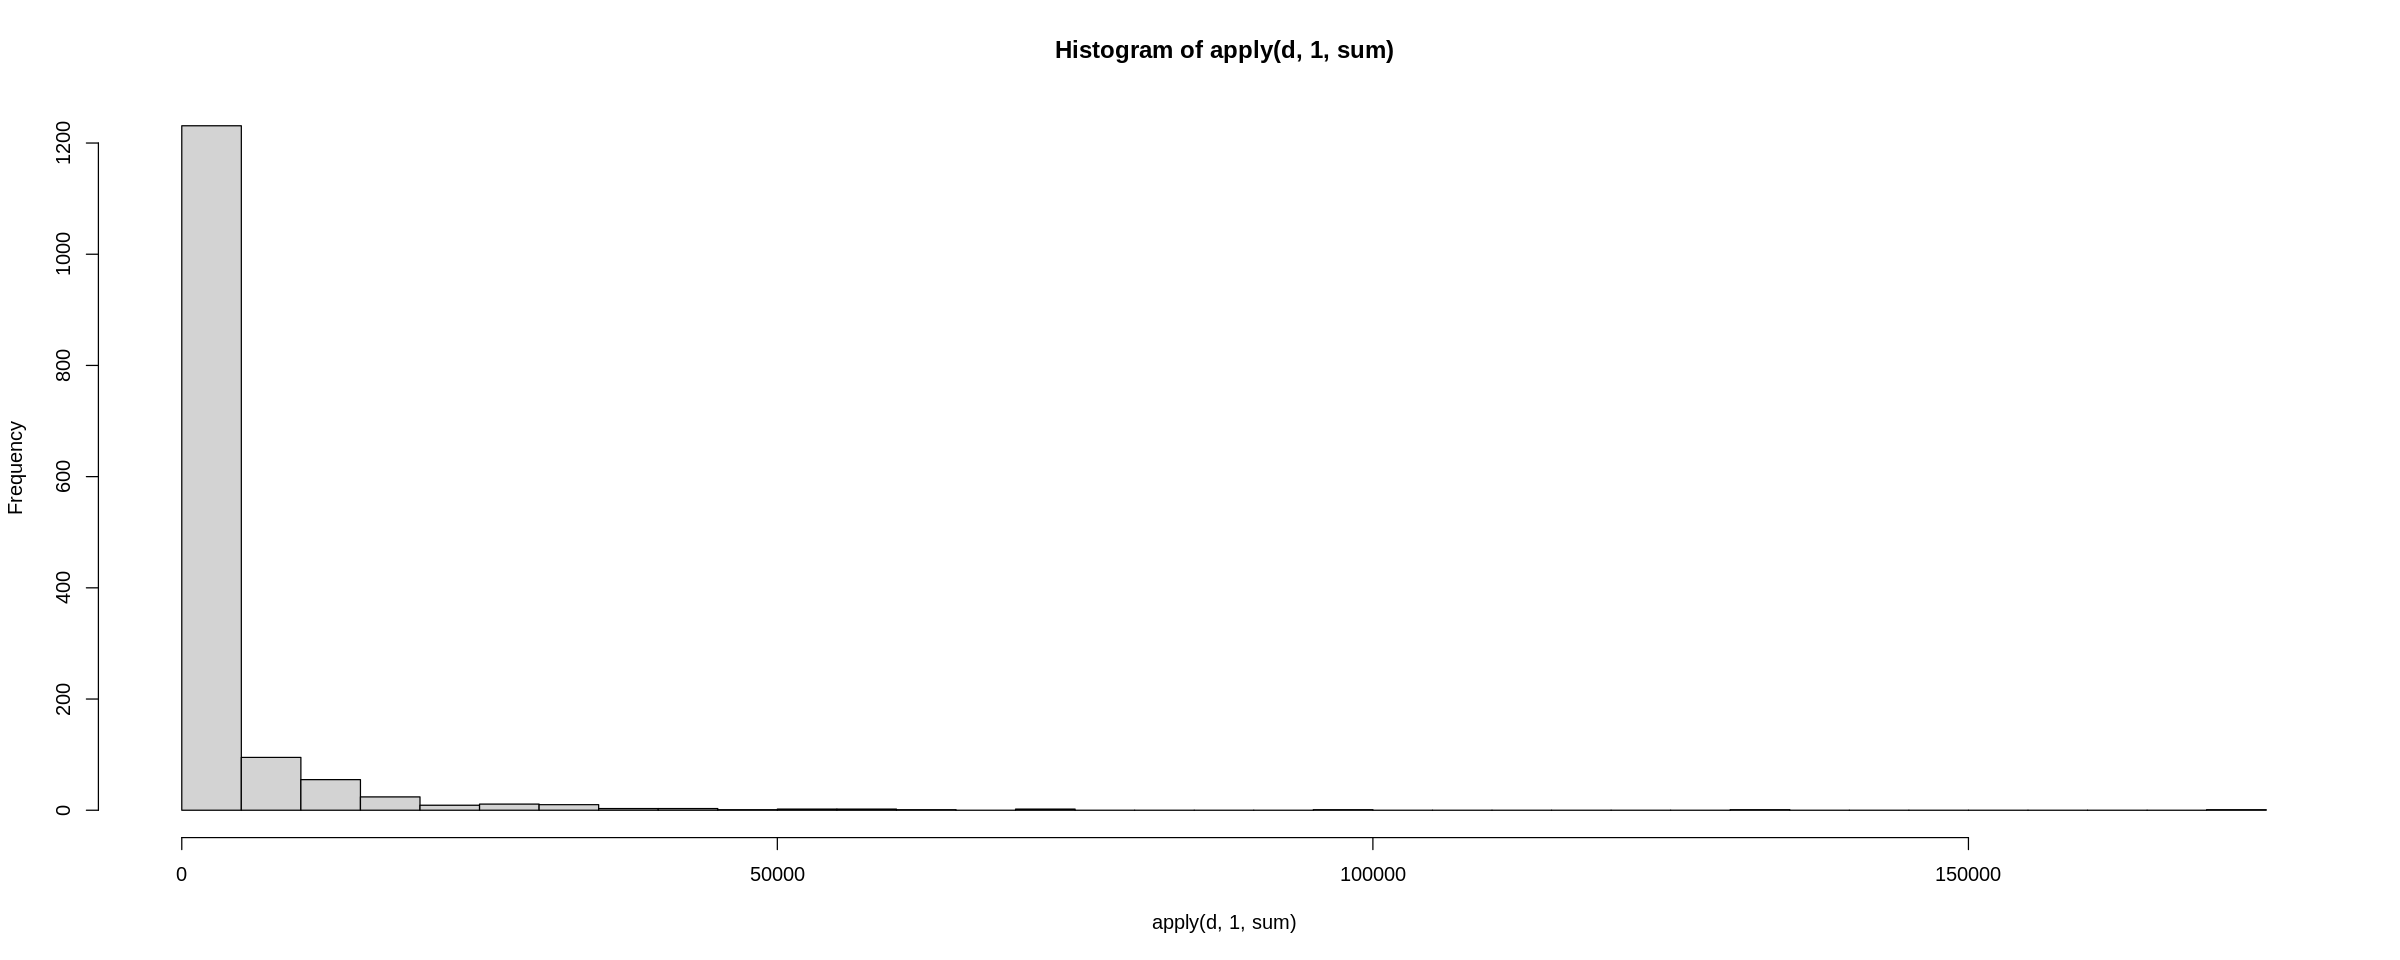

In [190]:
hist(apply(d,1,sum),40)

# remove genes with low level count (less then 9 counts)

In [191]:
table(apply(d,1,sum)>9)
d = d[apply(d,1,sum)>9,]


FALSE  TRUE 
  639   813 

# Normalize lib size

In [192]:
#y <- DGEList(GenewiseCounts[-c(1:2)], genes=GenewiseCounts[,1,drop=FALSE], group=Group)
#y = calcNormFactors(y,method='RLE') 
#options(digits=3)
#y$samples

# remove duplicates if any

In [193]:
#length(unique(GenewiseCounts$X))
#length(unique(GenewiseCounts$X)) == nrow(GenewiseCounts)

all genes are unique, in other cases use:

In [194]:
#o <- order(rowSums(y$counts), decreasing=TRUE)
#y <- y[o,]
#d <- duplicated(y$genes$Symbol)
#y <- y[!d,]
#nrow(y)

In [195]:
plotBCV(y)

ERROR: ignored

In [ ]:
edger = DGEList(d) 
edger = calcNormFactors(edger,method='RLE') 
edger$samples 

#2. Используя данные из предыдущего ДЗ при помощи edgeR найти гены с межтканевыми и/или возрастными изменениями экспресии 
1. (корректированное p-value < 0.05, межтканевые отличия должны быть не менее чем в два раза)
2. возрастные изменения можно считать линейными по возрасту. 
3. Используйте модель ~ tissue + age

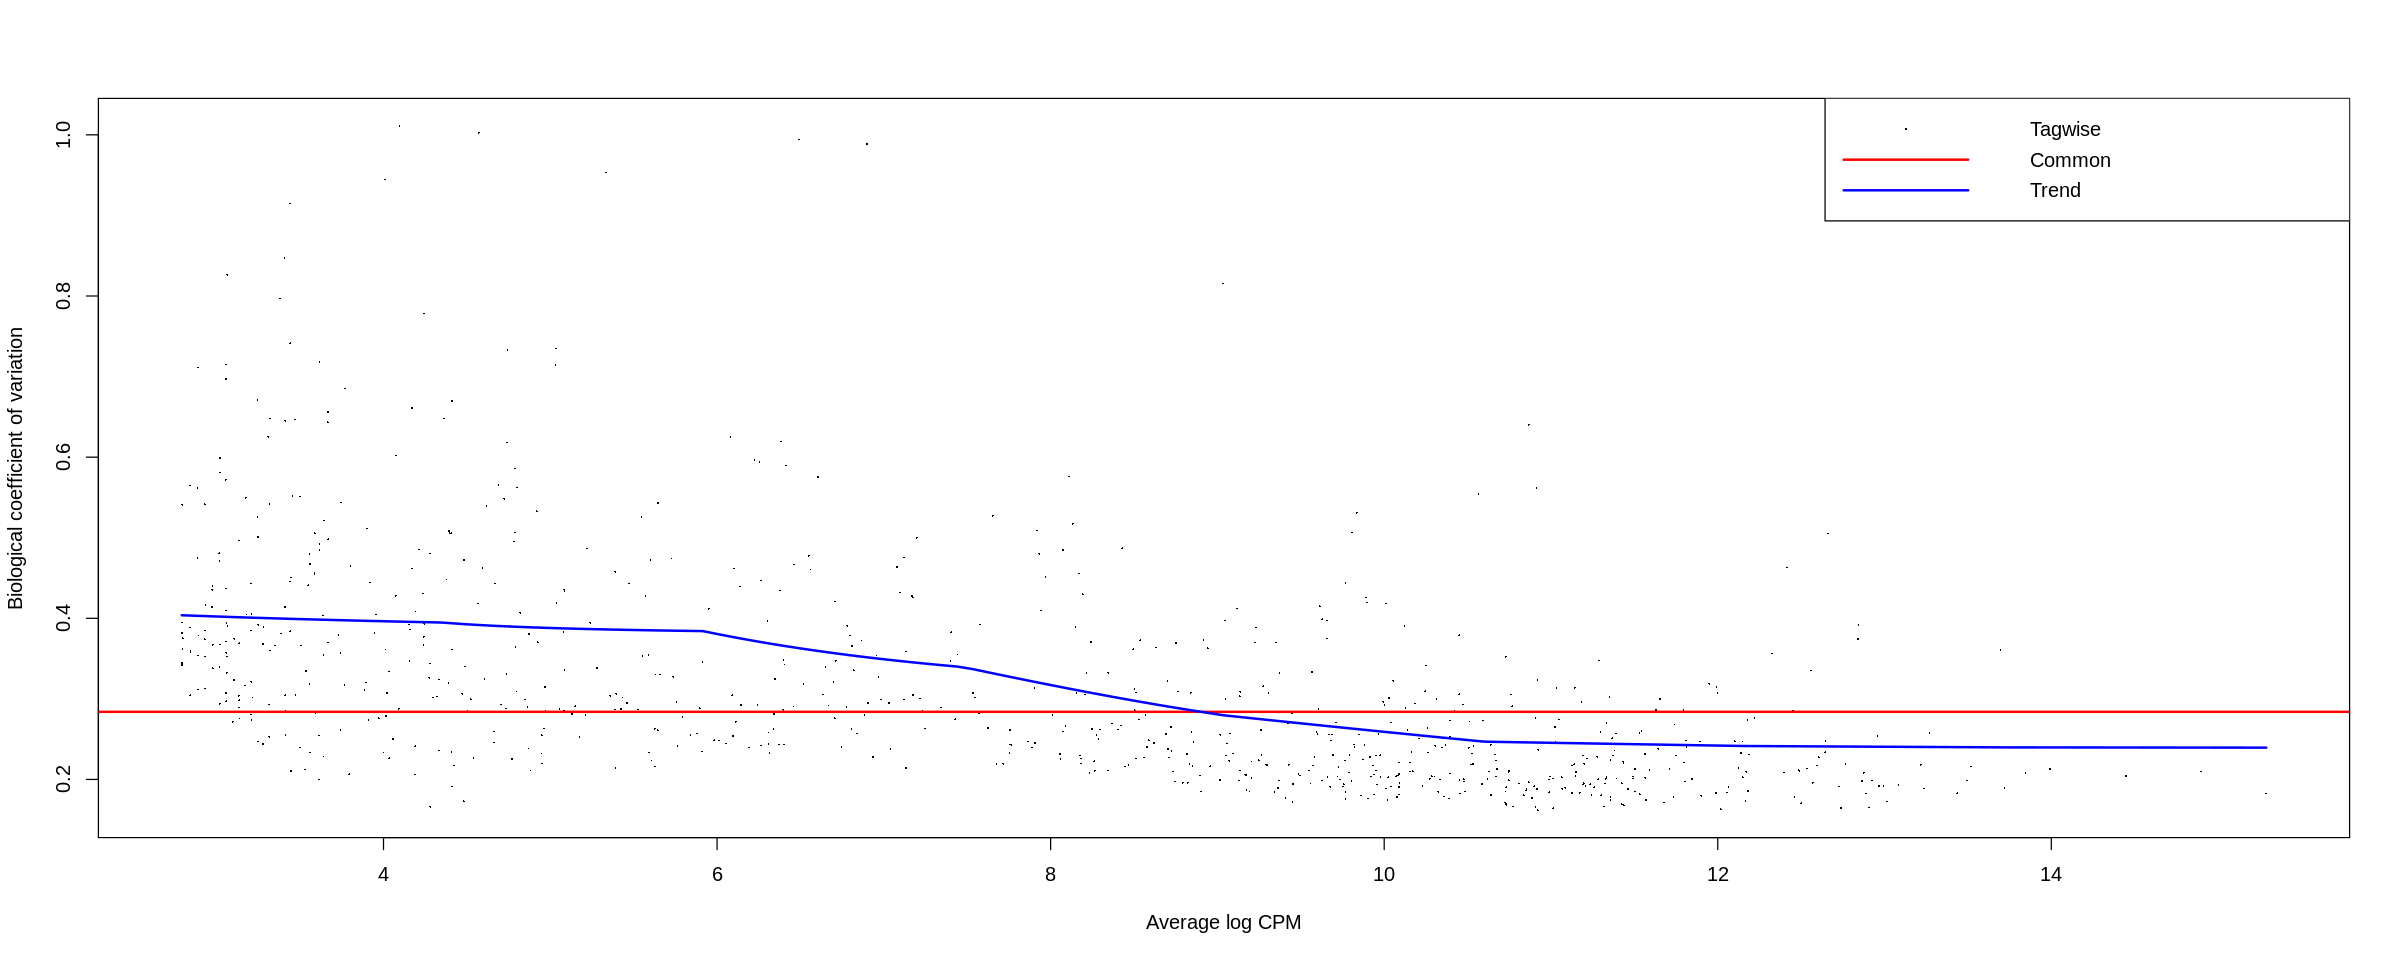

In [196]:
design = model.matrix(~ tissue + age, data = m) 
edger = estimateDisp(edger,design)  # estimate dispersion
plotBCV(edger)

In [197]:
y$common.dispersion

NULL

The square root of the common dispersion gives the coefficient of variation of biological variation. Here the common dispersion is found to be 0.07, so the coefficient of biological variation is around 0.3.

## examine the samples for outliers

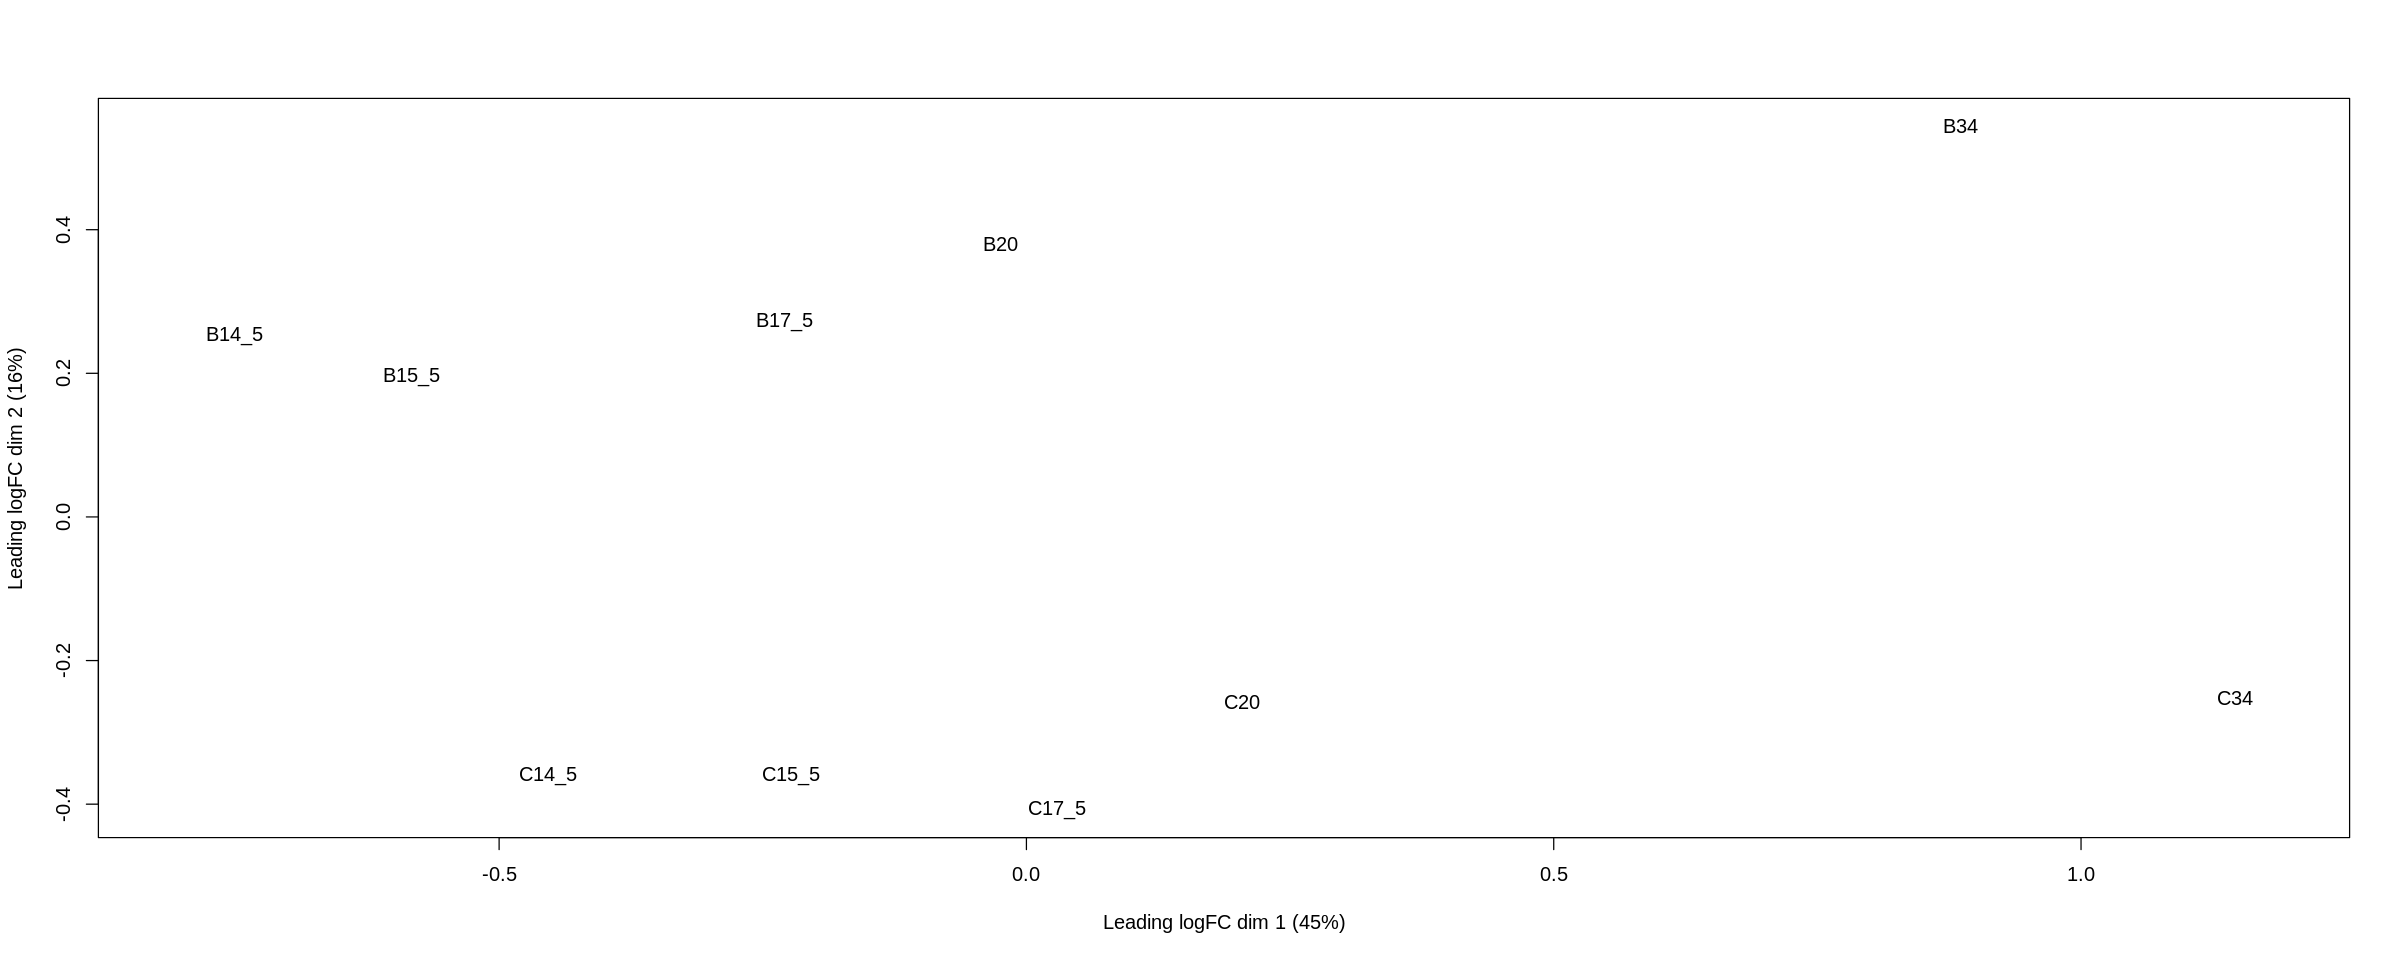

In [198]:
plotMDS(edger)

dim 1  separates the samples by age; dim 2 separates the samples by tissues


In [199]:
design

,(Intercept),tissueC,age
B14_5,1,0,14.5
B15_5,1,0,15.5
B17_5,1,0,17.5
B20,1,0,20.0
B34,1,0,34.0
C14_5,1,1,14.5
C15_5,1,1,15.5
C17_5,1,1,17.5
C20,1,1,20.0
C34,1,1,34.0


In [200]:
glm = glmFit(edger,design) # обучает линейную регрессию по нашим данным, модель - ткань+возраст

In [201]:
design

,(Intercept),tissueC,age
B14_5,1,0,14.5
B15_5,1,0,15.5
B17_5,1,0,17.5
B20,1,0,20.0
B34,1,0,34.0
C14_5,1,1,14.5
C15_5,1,1,15.5
C17_5,1,1,17.5
C20,1,1,20.0
C34,1,1,34.0


In [203]:
# head(glmLRT(glm)$table)
# таблица с logFC logCPM  LR PValue для генов

In [204]:
head(glmLRT(glm,3)$table)

,logFC,logCPM,LR,PValue
,<dbl>,<dbl>,<dbl>,<dbl>
ENSMUSG00000033863,0.308003,11.03,2.68e+02,3.08e-60
ENSMUSG00000006456,-0.051351,10.30,1.33e+01,2.61e-04
ENSMUSG00000095913,-0.038595,4.73,1.72e+00,1.89e-01
ENSMUSG00000025075,-0.172116,3.41,3.16e+00,7.57e-02
ENSMUSG00000034108,-0.000664,8.75,2.42e-03,9.61e-01
ENSMUSG00000067872,0.049045,5.55,1.51e+00,2.19e-01


In [205]:
head(glmLRT(glm,2)$table)

,logFC,logCPM,LR,PValue
,<dbl>,<dbl>,<dbl>,<dbl>
ENSMUSG00000033863,-0.583,11.03,3.821,0.0506
ENSMUSG00000006456,-0.242,10.30,1.616,0.2037
ENSMUSG00000095913,-0.141,4.73,0.129,0.7199
ENSMUSG00000025075,-0.521,3.41,0.273,0.6014
ENSMUSG00000034108,0.212,8.75,1.214,0.2705
ENSMUSG00000067872,-0.289,5.55,0.275,0.6002


In [206]:
glmLRT(glm)

An object of class "DGELRT"
$coefficients
                   (Intercept) tissueC      age
ENSMUSG00000033863      -11.68 -0.4039  0.21349
ENSMUSG00000006456       -5.91 -0.1679 -0.03559
ENSMUSG00000095913      -10.14 -0.0977 -0.02675
ENSMUSG00000025075       -9.61 -0.3614 -0.11930
ENSMUSG00000034108       -7.83  0.1472 -0.00046
808 more rows ...

$fitted.values
                    B14_5  B15_5  B17_5    B20      B34  C14_5  C15_5  C17_5
ENSMUSG00000033863  82.79 101.18 154.68 267.44 4811.460  54.29  67.11 103.66
ENSMUSG00000006456 716.88 682.89 634.26 588.18  323.210 595.42 573.72 538.37
ENSMUSG00000095913  11.66  11.20  10.58  10.02    6.196  10.37  10.08   9.62
ENSMUSG00000025075   5.31   4.57   3.46   2.48    0.327   3.61   3.14   2.40
ENSMUSG00000034108 174.05 171.73 171.11 173.25  155.713 198.12 197.73 199.06
                      C20      C34
ENSMUSG00000033863 191.01 3231.982
ENSMUSG00000006456 532.07  274.984
ENSMUSG00000095913   9.71    5.647
ENSMUSG00000025075   1.84    0.227

In [207]:
pv = cbind(tissue = glmLRT(glm,2)$table$PValue, 
           age = glmLRT(glm,3)$table$PValue)

In [208]:
rownames(pv) = rownames(d)

In [209]:
head(pv)

,tissue,age
ENSMUSG00000033863,0.0506,3.08e-60
ENSMUSG00000006456,0.2037,2.61e-04
ENSMUSG00000095913,0.7199,1.89e-01
ENSMUSG00000025075,0.6014,7.57e-02
ENSMUSG00000034108,0.2705,9.61e-01
ENSMUSG00000067872,0.6002,2.19e-01


In [210]:
qv = apply(pv,2,p.adjust,m='BH') # сделаем поправку на множественное тестирование
# BH - Benjamini method

In [211]:
apply(qv < 0.05, 2, sum) # количество генов значимых для каждого фактора

tissue    age 
    46    284

In [212]:
cpm = cpm(edger)

In [213]:
qv[order(qv[,2])[1:10],] # топ 10 дифференциально эксперссированных генов в зависимости от возраста

,tissue,age
ENSMUSG00000050121,0.05074,3.86e-69
ENSMUSG00000033863,0.29597,1.25e-57
ENSMUSG00000036098,0.07179,3.66e-56
ENSMUSG00000025190,0.05883,3.47e-41
ENSMUSG00000039126,0.00376,1.36e-37
ENSMUSG00000025189,0.52138,9.38e-26
ENSMUSG00000037071,0.55898,2.12e-24
ENSMUSG00000032648,0.05883,4.70e-24
ENSMUSG00000049303,0.04983,9.05e-23
ENSMUSG00000046324,0.32229,2.58e-22


In [214]:
qv[order(qv[,1])[1:10],] # топ 10 генов по тканеспецифичности

,tissue,age
ENSMUSG00000097683,1.02e-16,4.09e-03
ENSMUSG00000032773,1.54e-10,1.17e-04
ENSMUSG00000025229,8.35e-10,4.81e-02
ENSMUSG00000042372,4.37e-09,4.95e-06
ENSMUSG00000053279,4.37e-09,1.47e-12
ENSMUSG00000048138,8.38e-08,8.33e-01
ENSMUSG00000120254,1.21e-07,9.36e-01
ENSMUSG00000044220,4.38e-06,2.65e-13
ENSMUSG00000058624,4.68e-06,3.39e-06
ENSMUSG00000003559,6.81e-06,8.97e-01


In [215]:
head(m)

,tissue,age,col
,<chr>,<dbl>,<chr>
B14_5,B,14.5,purple
B15_5,B,15.5,purple
B17_5,B,17.5,purple
B20,B,20.0,purple
B34,B,34.0,purple
C14_5,C,14.5,blue


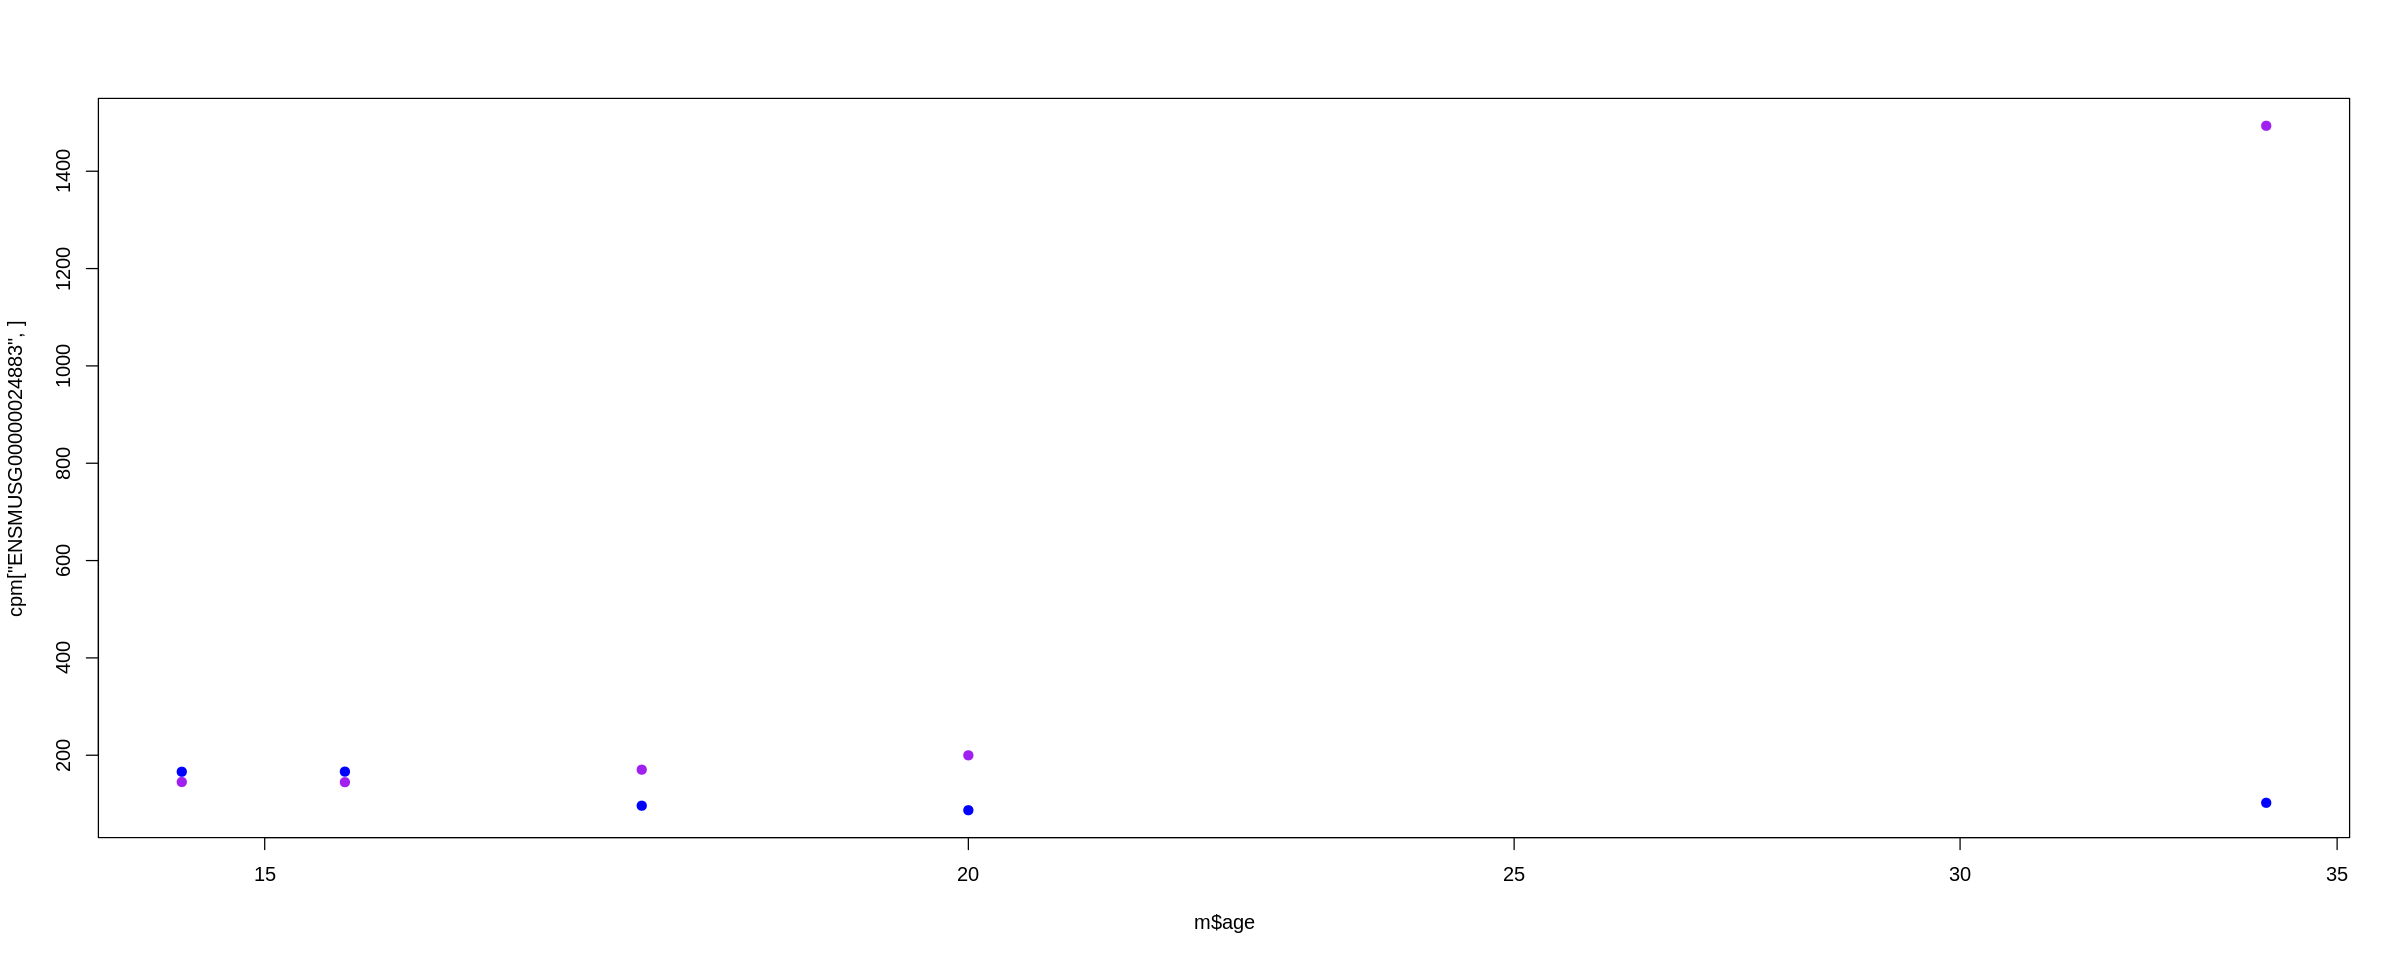

In [216]:
plot(m$age,cpm['ENSMUSG00000024883',],pch=19,col=m$col,log='x') # экспрессия растет в в коре но не в мозжечке. Правда изменения наблюдаются только в одном образце, поэтому нужны повторы


# Отшкалируйте экспрессию каждого гена к среднему ноль и дисперсии один (z-score)

In [217]:
cpm.s = cpm[apply(qv,1,min)<0.05,] # take significant genes (by tissue = 1; by age = 2)
cpm.s = t(scale(t(cpm.s))) # z-score scaling
head(cpm.s)

,B14_5,B15_5,B17_5,B20,B34,C14_5,C15_5,C17_5,C20,C34
ENSMUSG00000033863,-0.519,-0.5104,-0.433,-0.2801,2.322,-0.514,-0.493,-0.49549,-0.4416,1.3652
ENSMUSG00000006456,1.096,1.6683,0.630,-0.4713,-1.328,-0.463,0.777,-0.24683,-0.4003,-1.2622
ENSMUSG00000083282,-0.951,-0.6828,-0.480,-0.4127,0.624,-0.377,-0.282,0.00794,-0.0188,2.5722
ENSMUSG00000044424,1.187,0.7146,0.576,0.2037,-1.533,0.354,0.217,0.77492,-0.7601,-1.7339
ENSMUSG00000051255,1.805,-0.0482,0.331,0.0666,-1.232,1.417,-0.458,0.00369,-0.7044,-1.1804
ENSMUSG00000024897,-1.432,-1.0670,-0.324,0.2569,1.698,-0.771,-0.294,0.91752,1.1071,-0.0907


# Скалстеризуйте гены значимые хотя бы по одному фактору при помощи иерархической кластеризации (расстояние 1 — коэффициент корреляции Спирмана) в 6 кластеров.

In [218]:
hcl = hclust(as.dist(1-cor(t(cpm.s)))) # иерархическая кластеризация

In [219]:
cl = cutree(hcl,6) #  отсекает 6 кластеров
table(cl) # число генов в каждом кластере

cl
 1  2  3  4  5  6 
63 54 83 62 14 23 

In [221]:
options(repr.plot.width=20, repr.plot.height=8)

Warning message in min(x):
“no non-missing arguments to min; returning Inf”
Warning message in max(x):
“no non-missing arguments to max; returning -Inf”
Warning message in min(x):
“no non-missing arguments to min; returning Inf”
Warning message in max(x):
“no non-missing arguments to max; returning -Inf”


ERROR: ignored

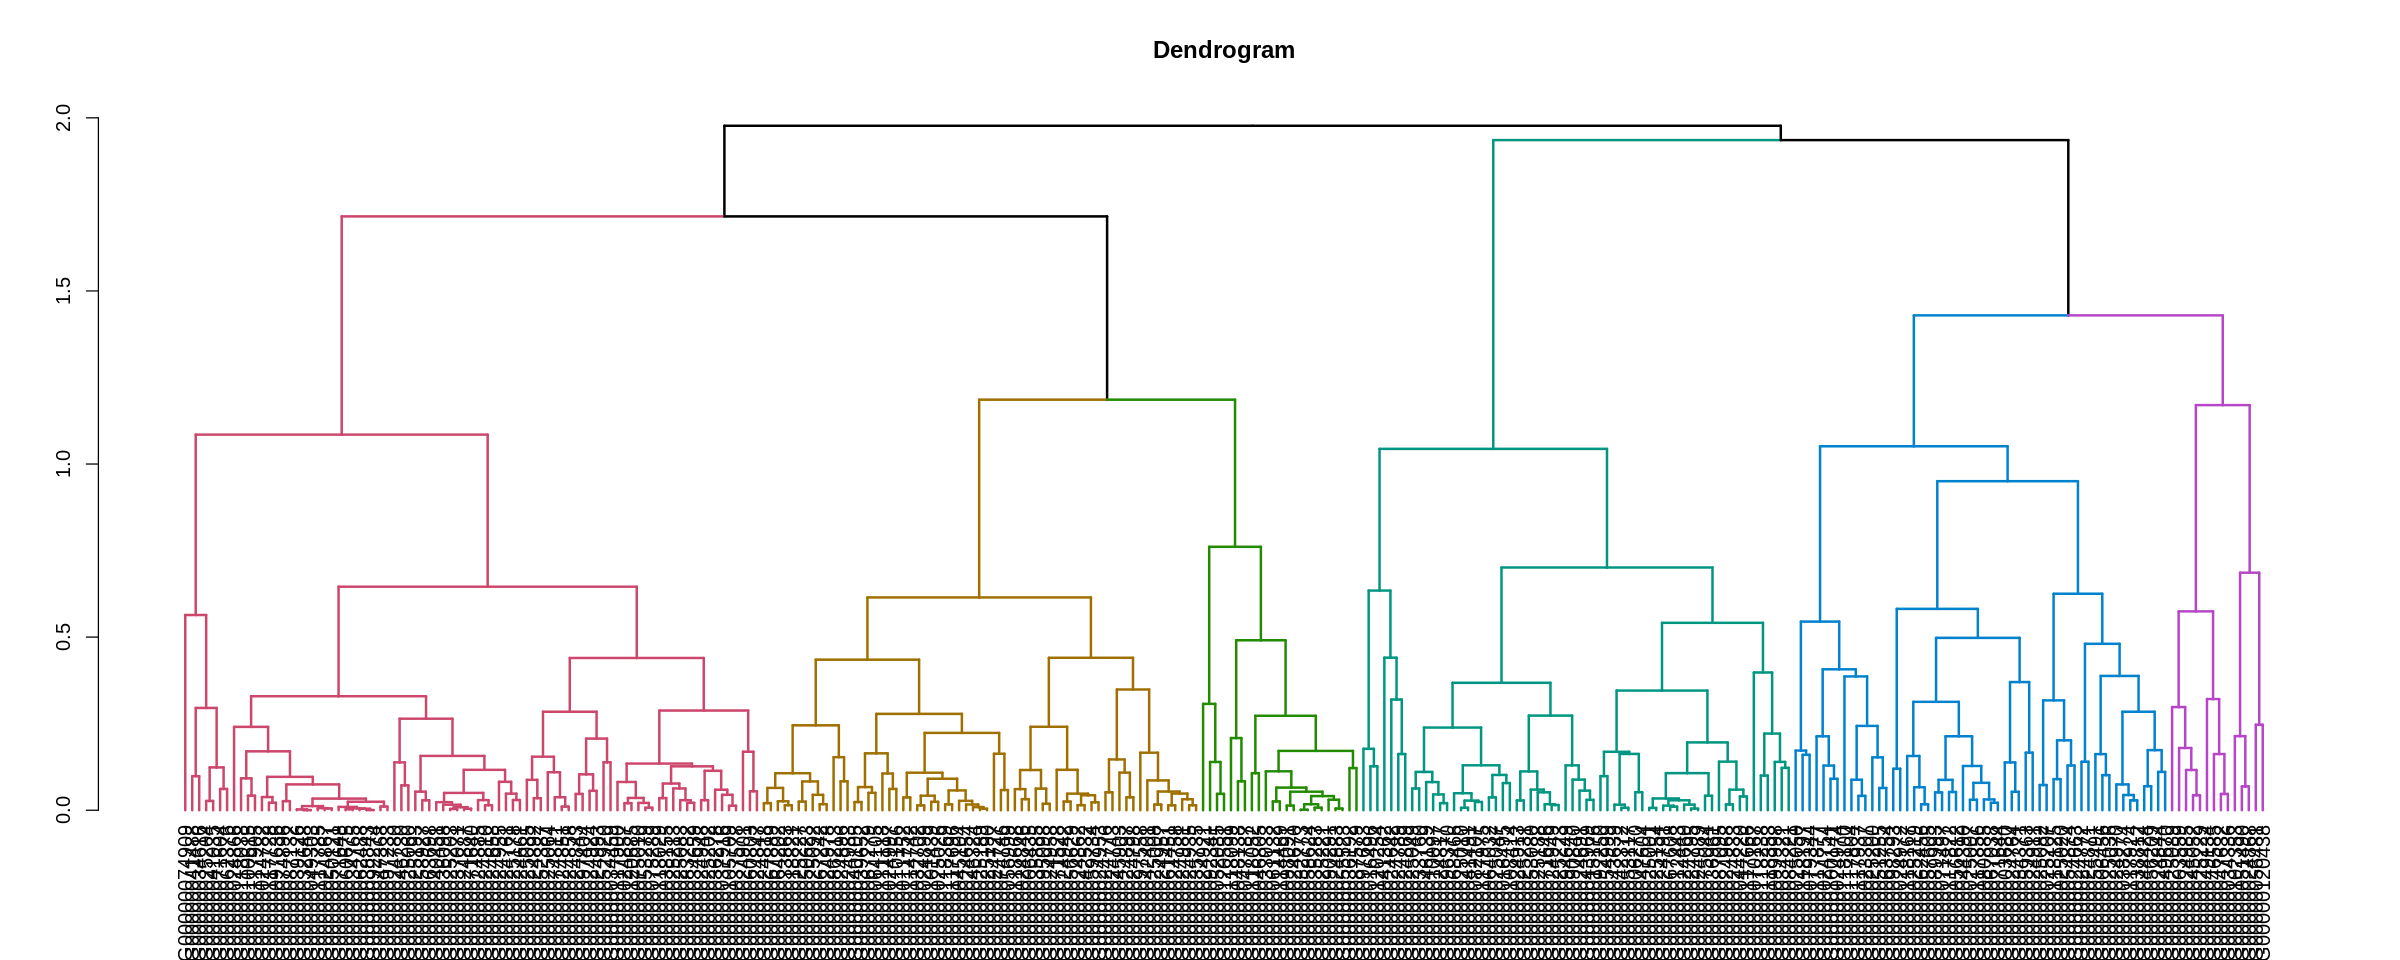

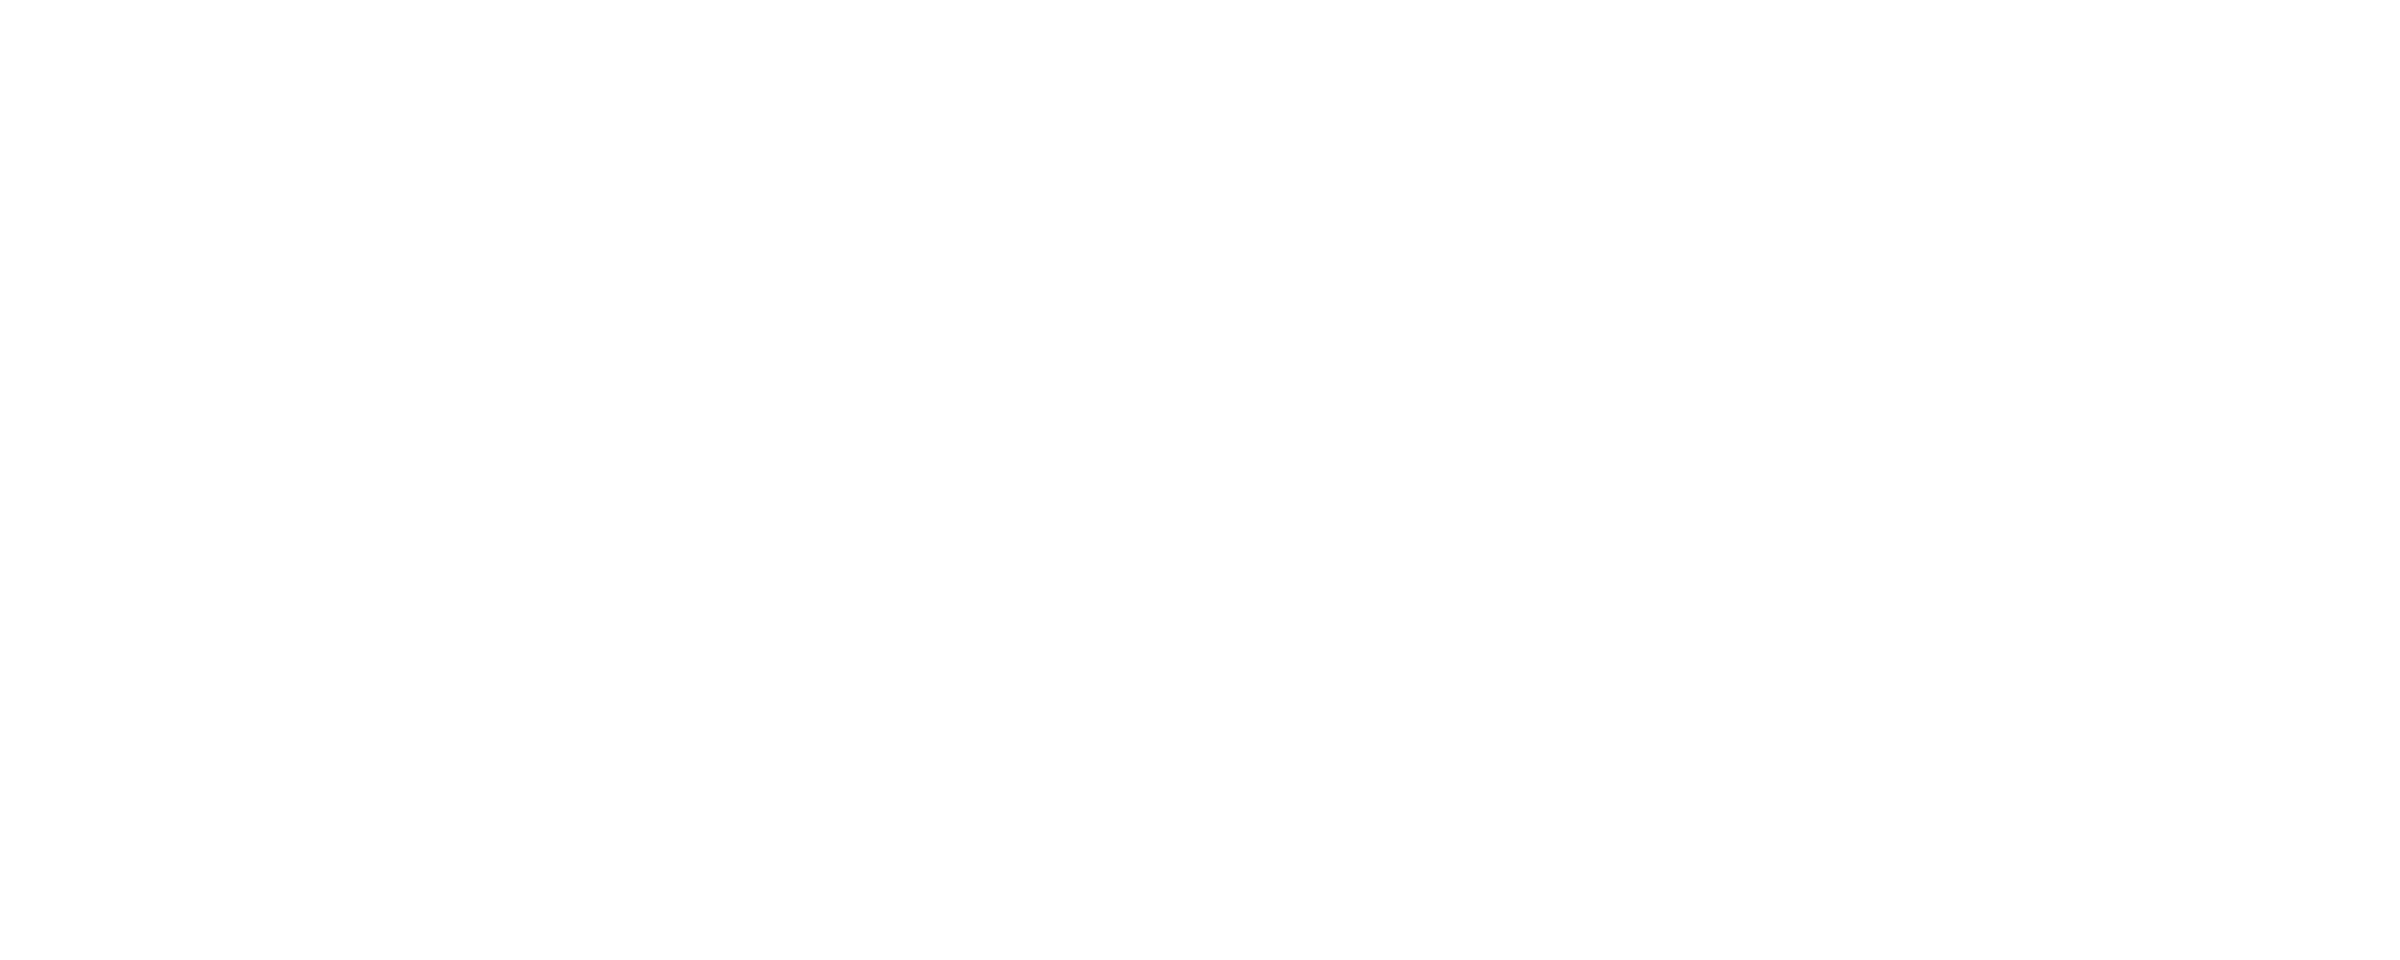

In [222]:
dend <- as.dendrogram(hcl)
dend <- dend %>% color_branches(k = 6) %>% set("branches_lwd", 2) %>% plot(main = "Dendrogram")

plot(dend)

# Нарисуйте для каждого кластера зависимость среднего z-score от возраста для обоих тканей

In [223]:
unique(cl)

[1] 1 2 3 4 5 6

In [224]:
#for(clust in unique(cl)){  
#  means = apply(cpm.s[cl==clust,,drop=F],2,mean)  # средние экспресси для данного кластера
#  plot(m$age,means,pch=19,col=m$col,main=paste0('c1',' (',sum(cl==1),')'),log='x',cex=2) # рисуем средние занчения
#
#
#  for(t in unique(m$tissue)){  # перебираем ткани 
#    f = m$tissue == t # отбираем образцы относящиеся к данной ткани
#    ss = smooth.spline(m$age[f],means[f],df=4) # апроксимируем зависимость сплайном
#    ss = predict(ss,seq(min(m$age),max(m$age),length.out=100)) # интерполируем
#    lines(ss,lwd=3,col=m$col[f][1]) # рисуем апроксимацию
#  }
#}




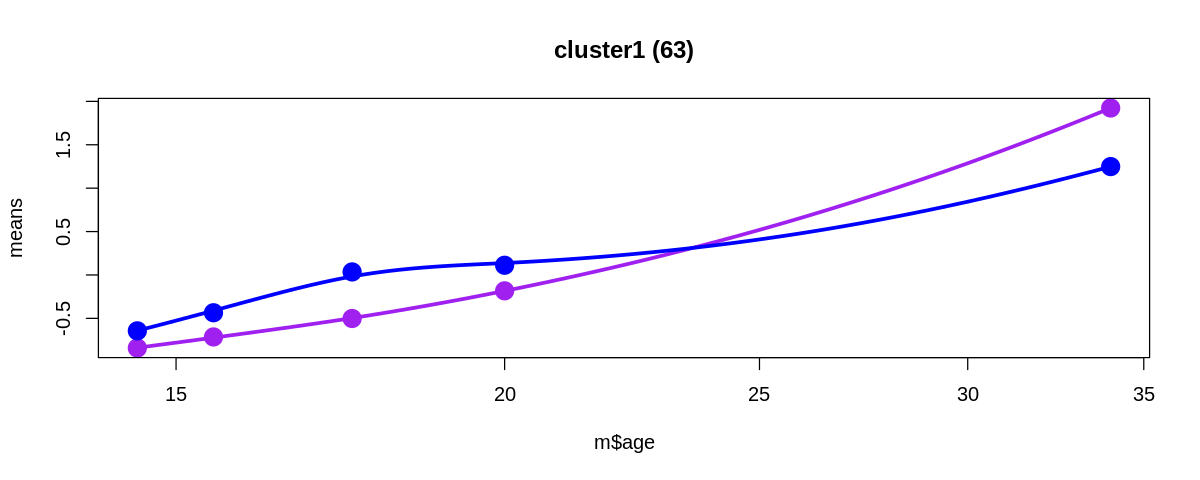

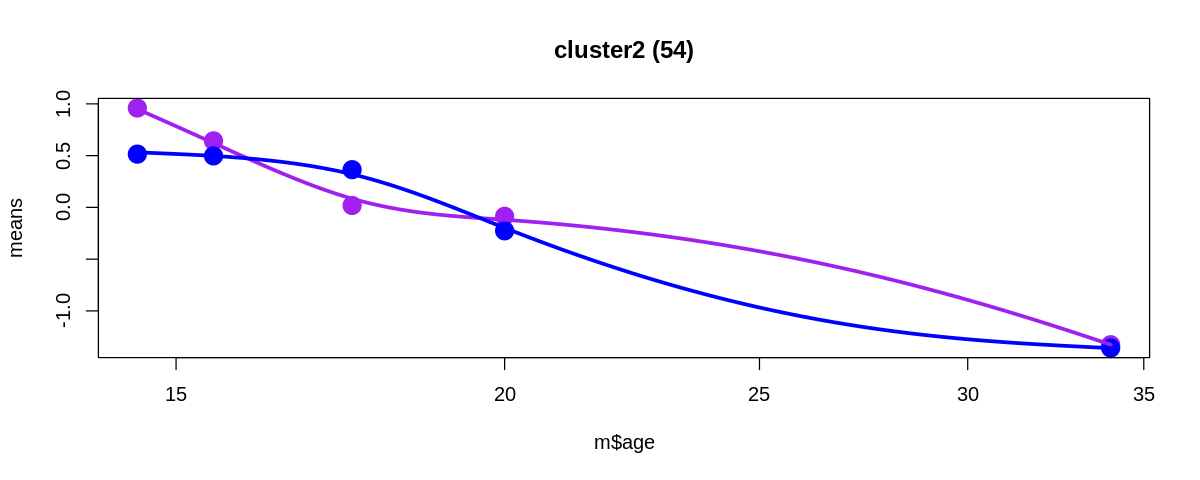

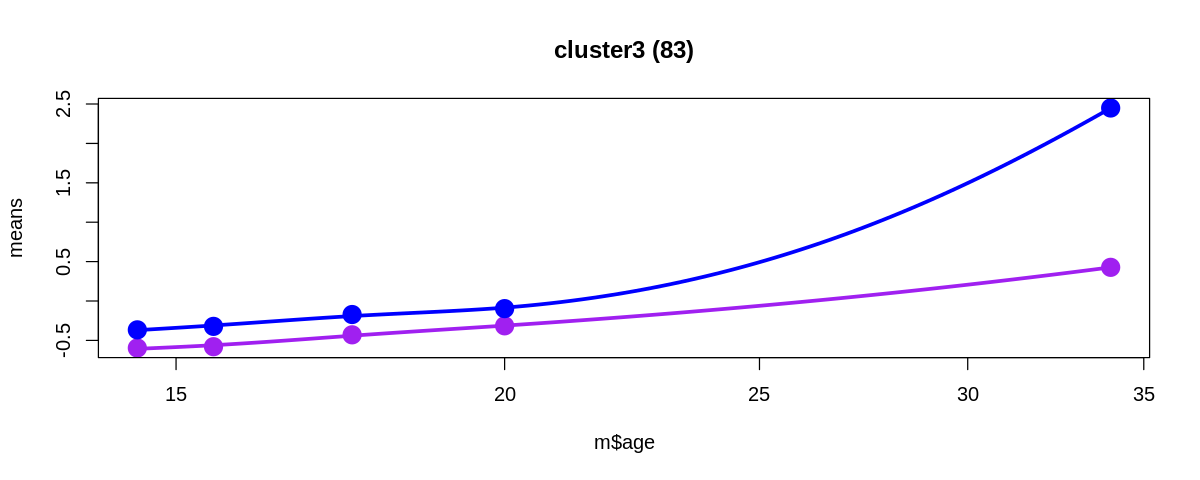

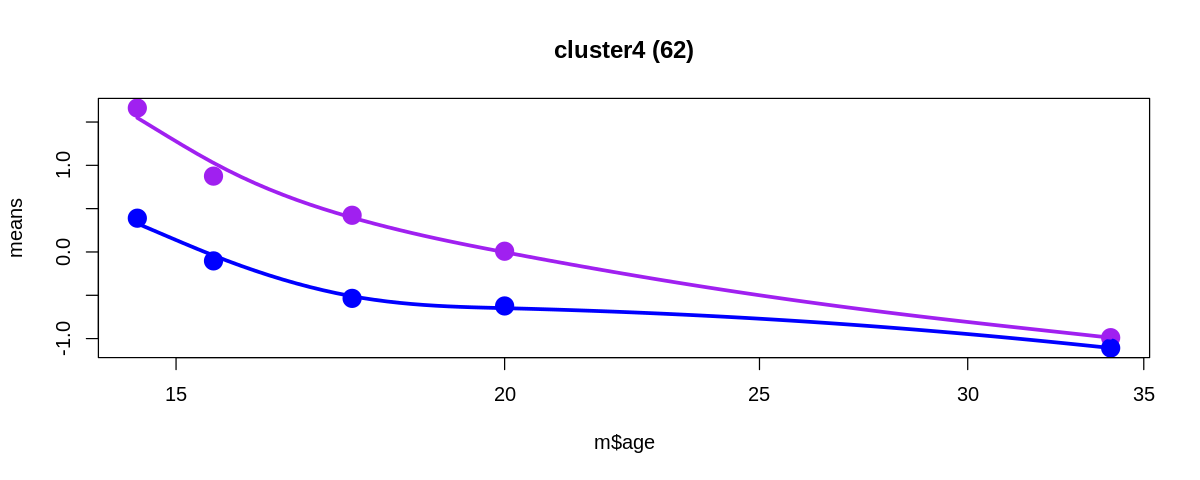

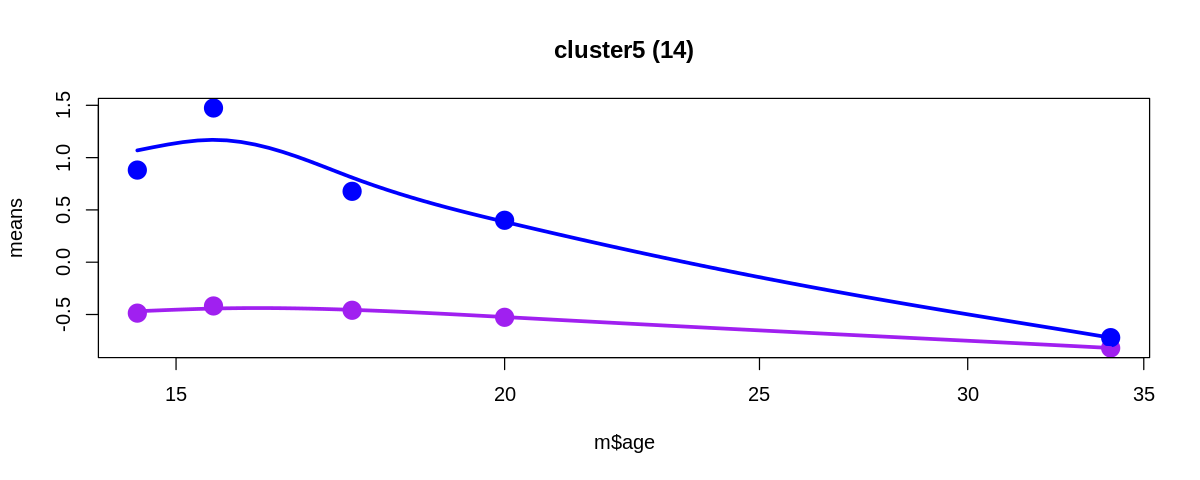

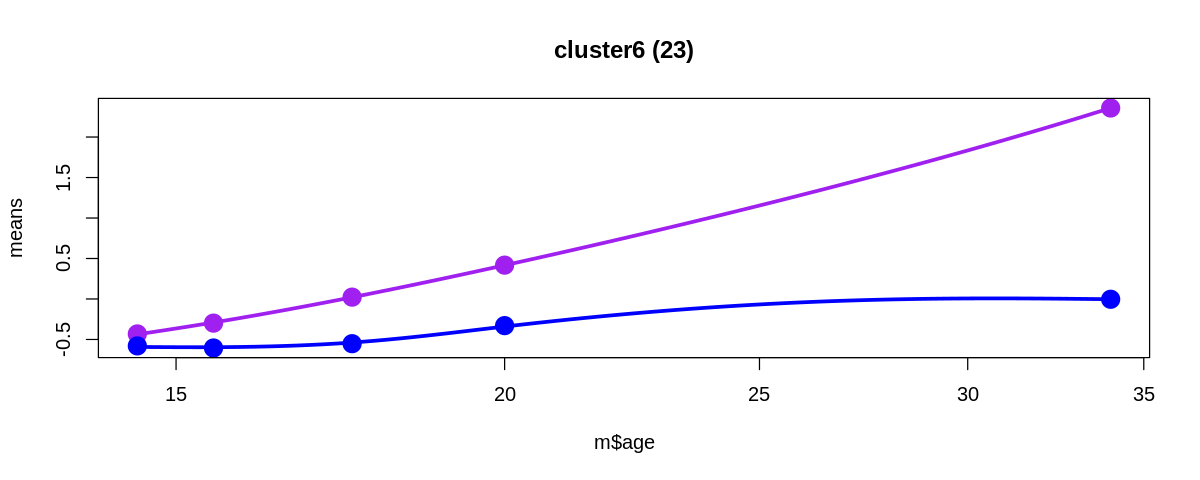

In [230]:
options(repr.plot.width=10, repr.plot.height=4)
for(clustno in unique(cl)){  
  means = apply(cpm.s[cl==clustno,,drop=F],2,mean)  # средние экспресси для данного кластера
  plot(m$age,means,pch=19,col=m$col,main=paste0(sprintf("cluster%s", clustno),' (',sum(cl==clustno),')'),log='x',cex=2) # рисуем средние занчения

  #sprintf("fig%s", clustno) <- 
  #fig <- subplot(fig1, fig2, fig3, fig4, fig5, fig6, nrows = 6, shareX = TRUE) %>% -- non language object - how to make subplots?

  for(t in unique(m$tissue)){  # перебираем ткани 
    f = m$tissue == t # отбираем образцы относящиеся к данной ткани
    ss = smooth.spline(m$age[f],means[f],df=4) # апроксимируем зависимость сплайном
    ss = predict(ss,seq(min(m$age),max(m$age),length.out=100)) # интерполируем
    lines(ss,lwd=3,col=m$col[f][1]) # рисуем апроксимацию
  }
}